# Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier

# Obtain Data

In [2]:
df = pd.read_csv('../Data/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Scrub Data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Drop columns not useful for modeling

In [4]:
df.drop(columns=['PassengerId', 'Ticket', 'Cabin', 'Parch', 'SibSp', 'Name', 'Age', 'Fare'], inplace=True)
df.head()

,Survived,Pclass,Sex,Embarked
0,0,3,male,S
1,1,1,female,C
2,1,3,female,S
3,1,1,female,S
4,0,3,male,S


Create dummy columns for Pclass and Sex categorical variables

In [5]:
df = pd.get_dummies(df, columns=['Pclass', 'Sex'], drop_first=False)
df.drop(columns=['Pclass_2', 'Sex_female'], inplace=True)
df.head()

,Survived,Embarked,Pclass_1,Pclass_3,Sex_male
0,0,S,0,1,1
1,1,C,1,0,0
2,1,S,0,1,0
3,1,S,1,0,0
4,0,S,0,1,1


Create dummy columns for Embarked variable, while mantaining Embarked np.nan values in the dummy columns

In [6]:
df = pd.get_dummies(df, columns=['Embarked'], drop_first=False, dummy_na=True)
df.drop(columns=['Embarked_Q'], inplace=True)

def embarked_na(row):
    if row['Embarked_nan'] == 1:
        row['Embarked_S'] = np.nan
        row['Embarked_C'] = np.nan
        return row
    else:
        return row

df = df.apply(embarked_na, axis=1)
df.drop(columns='Embarked_nan', inplace=True)
df.head()

,Survived,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S
0,0.0,0.0,1.0,1.0,0.0,1.0
1,1.0,1.0,0.0,0.0,1.0,0.0
2,1.0,0.0,1.0,0.0,0.0,1.0
3,1.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,1.0,0.0,1.0


Impute missing age values with knn imputer

In [7]:
impute_x = df.drop(columns=['Survived'])
impute_y = df['Survived']

impute_xtrain, impute_xtest, impute_ytrain, impute_ytest = train_test_split(impute_x, impute_y, 
                                                                            test_size=0.25, random_state=121)

impute_ss = StandardScaler()
impute_ss.fit(impute_xtrain)
impute_xtrain = pd.DataFrame(impute_ss.transform(impute_xtrain), columns=impute_xtrain.columns, 
                             index=impute_xtrain.index)
impute_x = pd.DataFrame(impute_ss.transform(impute_x), columns=impute_x.columns, index=impute_x.index)

imputer = KNNImputer()
imputer.fit(impute_xtrain)
impute_x = pd.DataFrame(imputer.transform(impute_x), columns=impute_x.columns, index=impute_x.index)

impute_x = pd.DataFrame(impute_ss.inverse_transform(impute_x), columns=impute_x.columns, index=impute_x.index)
df = pd.concat([impute_x, impute_y], axis=1)
df = df.round(4)
df.head()

,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S,Survived
0,0.0,1.0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.0,1.0,0.0,1.0
2,0.0,1.0,0.0,0.0,1.0,1.0
3,1.0,0.0,0.0,0.0,1.0,1.0
4,0.0,1.0,1.0,0.0,1.0,0.0


Confirm data now scrubbed with df.info()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass_1    891 non-null    float64
 1   Pclass_3    891 non-null    float64
 2   Sex_male    891 non-null    float64
 3   Embarked_C  891 non-null    float64
 4   Embarked_S  891 non-null    float64
 5   Survived    891 non-null    float64
dtypes: float64(6)
memory usage: 41.9 KB


# Explore Data

Find train set outliers with isolation forest

In [9]:
isf_x = df.drop(columns='Survived')
isf_y = df['Survived']
isf_xtrain, isf_xtest, isf_ytrain, isf_ytest = train_test_split(isf_x, isf_y, test_size=0.25, random_state=121)

isf_ss = StandardScaler()
isf_ss.fit(isf_xtrain)
isf_xtrain = pd.DataFrame(isf_ss.transform(isf_xtrain), columns=isf_xtrain.columns, index=isf_xtrain.index)

isf = IsolationForest(contamination=.02)
isf_xtrain['Outlier'] = isf.fit_predict(isf_xtrain)
isf_xtrain[isf_xtrain['Outlier']==-1].round(1)

C:\Users\blant\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S,Outlier
308,-0.5,-1.1,0.7,2.1,-1.6,-1
827,-0.5,-1.1,0.7,2.1,-1.6,-1
874,-0.5,-1.1,-1.4,2.1,-1.6,-1
361,-0.5,-1.1,0.7,2.1,-1.6,-1
547,-0.5,-1.1,0.7,2.1,-1.6,-1
389,-0.5,-1.1,-1.4,2.1,-1.6,-1
473,-0.5,-1.1,-1.4,2.1,-1.6,-1
292,-0.5,-1.1,0.7,2.1,-1.6,-1
817,-0.5,-1.1,0.7,2.1,-1.6,-1
135,-0.5,-1.1,0.7,2.1,-1.6,-1


Find test set outliers with Isolation Forest

In [10]:
isf_xtest = pd.DataFrame(isf_ss.transform(isf_xtest), columns=isf_xtest.columns, index=isf_xtest.index)
isf_xtest['Outlier'] = isf.predict(isf_xtest)
isf_xtest[isf_xtest['Outlier']==-1].round(1)

,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S,Outlier
43,-0.5,-1.1,-1.4,2.1,-1.6,-1
866,-0.5,-1.1,-1.4,2.1,-1.6,-1
122,-0.5,-1.1,0.7,2.1,-1.6,-1
9,-0.5,-1.1,-1.4,2.1,-1.6,-1


Calculate descriptive statistics for each feature

In [11]:
df.describe().iloc[:, 0:10]

,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S,Survived
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.242424,0.551066,0.647587,0.188552,0.725028,0.383838
std,0.428790,0.497665,0.477990,0.391372,0.446751,0.486592
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Plot class distribution for Survived dependent variable

[Text(0, 0, '0 (Non-Survivor)'), Text(1, 0, '1 (Survivor)')]

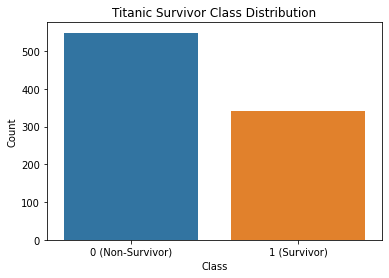

In [12]:
fig, ax = plt.subplots()
sns.countplot(x='Survived', data=df, ax=ax)
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Titanic Survivor Class Distribution')
ax.set_xticklabels(['0 (Non-Survivor)', '1 (Survivor)'])

Plot distribution for each feature in Titanic dataset

C:\Users\blant\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\blant\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\blant\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

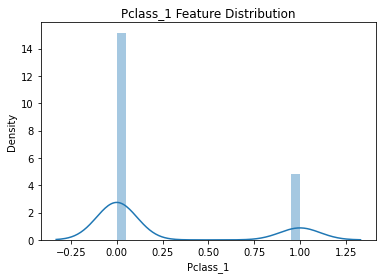

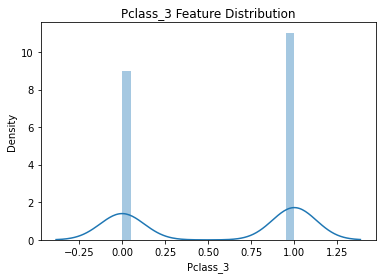

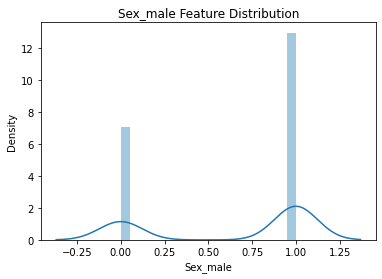

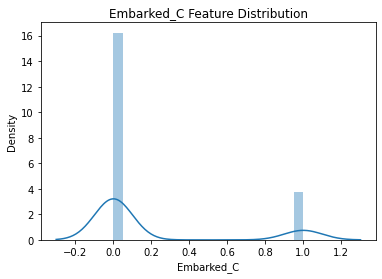

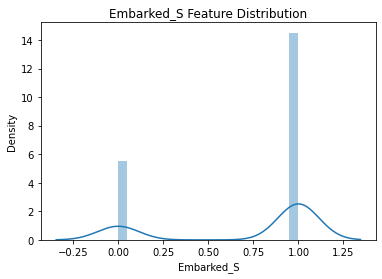

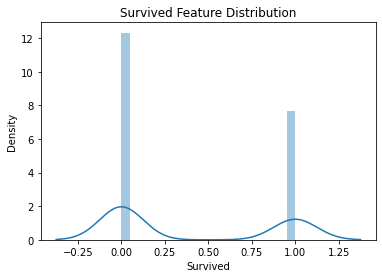

In [13]:
for feat in df.columns:
    fig, ax = plt.subplots()
    sns.distplot(df[feat], kde=True, bins=20)
    ax.set_title(f'{feat} Feature Distribution')

Calculate VIF to confirm that there are no correlated features

In [14]:
vif_x = df.drop(columns=['Survived'])
vif_y = df['Survived']
vif_x_train, vif_x_test, vif_y_train, vif_y_test = train_test_split(vif_x, vif_y, test_size=0.25, random_state=121)

vif_df = add_constant(vif_x_train)
vif_output = []
for num in range(0, len(vif_df.columns)):
    vif_output.append([vif_df.columns[num], variance_inflation_factor(vif_df.values, num)])
vif_output_df = pd.DataFrame(vif_output, columns=['Column', 'VIF'])
vif_output_df.sort_values(by='VIF', ascending=False, inplace=True)
vif_output_df.reset_index(drop=True, inplace=True)
vif_output_df.round(1)

,Column,VIF
0,const,18.4
1,Embarked_C,2.8
2,Embarked_S,2.7
3,Pclass_1,1.8
4,Pclass_3,1.7
5,Sex_male,1.0


# Model Data

Create x and y variables

In [15]:
x = df.drop(columns=['Survived'])
y = df['Survived']

Perform train test split

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=121)

Standard scale data

In [17]:
ss = StandardScaler()
ss.fit(x_train)
x_train = pd.DataFrame(ss.transform(x_train), columns=x_train.columns, index=x_train.index)
x_test = pd.DataFrame(ss.transform(x_test), columns=x_test.columns, index=x_test.index)

Build and evaluate dummy classifier

In [251]:
dc = DummyClassifier(strategy='stratified', random_state=73)
dc.fit(x_train, y_train)
y_train_pred_dc = dc.predict(x_train)
y_test_pred_dc = dc.predict(x_test)
print('Dummy Classifier: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_dc))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_dc))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_dc))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_dc))

Dummy Classifier: 
Train f1 Score:  0.33954451345755693
Train Accuracy Score: 0.5224550898203593
Test f1 Score:  0.28205128205128205
Test Accuracy Score: 0.4977578475336323


Gridsearch Logistic Regression Model

In [21]:
lr_gs_dict = {'C': [x/1000 for x in range(1, 101)]}
lr_gs_model = LogisticRegression(random_state=204)
lr_gs = GridSearchCV(lr_gs_model, lr_gs_dict, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
lr_gs.fit(x_train, y_train)

print(lr_gs.best_estimator_)
print(lr_gs.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
LogisticRegression(C=0.013, random_state=204)
0.8099091011109865


Build and evaluate top performing gridsearch logistic regression model

In [19]:
lr = LogisticRegression(C=.013, random_state=204)
lr.fit(x_train, y_train)
y_train_pred_lr = lr.predict(x_train)
y_test_pred_lr = lr.predict(x_test)
print('Logistic Regression: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_lr))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_lr))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_lr))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_lr))

Logistic Regression: 
Train f1 Score:  0.7030878859857482
Train Accuracy Score: 0.812874251497006
Test f1 Score:  0.7074829931972789
Test Accuracy Score: 0.8071748878923767


Create logistic regression Confusion Matrix

[Text(0, 0.5, 'Non-Survivor'), Text(0, 1.5, 'Survivor')]

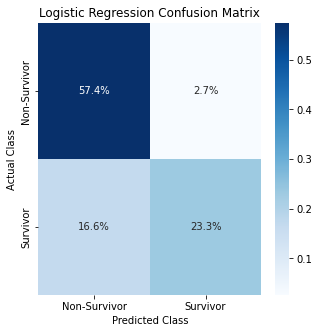

In [20]:
cm = confusion_matrix(y_test, y_test_pred_lr)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(cm/np.sum(cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('Logistic Regression Confusion Matrix')
matrix.set_xlabel('Predicted Class')
matrix.set_xticklabels(['Non-Survivor', 'Survivor'])
matrix.set_ylabel('Actual Class')
matrix.set_yticklabels(['Non-Survivor', 'Survivor'])

Gridsearch SVC model

In [28]:
svc_gs_dict = {'C': [x/1000 for x in range(50, 101)],
               'gamma': [x/1000 for x in range(250, 301)]}
svc_gs_model = SVC(random_state=491)
svc_gs = GridSearchCV(svc_gs_model, svc_gs_dict, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
svc_gs.fit(x_train, y_train)

print(svc_gs.best_estimator_)
print(svc_gs.best_score_)

Fitting 5 folds for each of 2601 candidates, totalling 13005 fits
SVC(C=0.067, gamma=0.271, random_state=491)
0.8128941757378522


Fit and evaluate top performing SVC model

In [103]:
svc = SVC(C=.067, gamma=.271, random_state=491, probability=True)
svc.fit(x_train, y_train)
y_train_pred_svc = svc.predict(x_train)
y_test_pred_svc = svc.predict(x_test)
print('SVC: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_svc))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_svc))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_svc))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_svc))

SVC: 
Train f1 Score:  0.7030878859857482
Train Accuracy Score: 0.812874251497006
Test f1 Score:  0.7074829931972789
Test Accuracy Score: 0.8071748878923767


Create SVC Confusion Matrix

[Text(0, 0.5, 'Non-Survivor'), Text(0, 1.5, 'Survivor')]

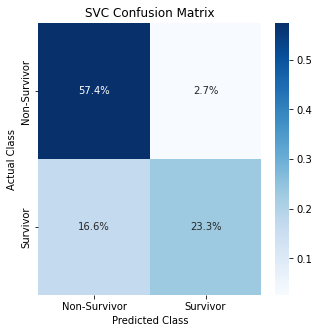

In [22]:
cm = confusion_matrix(y_test, y_test_pred_svc)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(cm/np.sum(cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('SVC Confusion Matrix')
matrix.set_xlabel('Predicted Class')
matrix.set_xticklabels(['Non-Survivor', 'Survivor'])
matrix.set_ylabel('Actual Class')
matrix.set_yticklabels(['Non-Survivor', 'Survivor'])

Gridsearch adaboost model

In [37]:
ab_gs_dict = {'learning_rate': [x/10000 for x in range(0, 201)],
             'n_estimators': [x*10 for x in range(5, 11)]}
ab_gs_model = AdaBoostClassifier(random_state=19)
ab_gs = GridSearchCV(ab_gs_model, ab_gs_dict, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
ab_gs.fit(x_train, y_train)

print(ab_gs.best_estimator_)
print(ab_gs.best_score_)

Fitting 5 folds for each of 1206 candidates, totalling 6030 fits
AdaBoostClassifier(learning_rate=0.0001, random_state=19)
0.7979126921782067


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.79791269 0.79791269 0.79791269]
  warnings.warn(


Fit and evaluate top performing adaboost model

In [23]:
ab = AdaBoostClassifier(learning_rate=.0001, n_estimators=50, random_state=19)
ab.fit(x_train, y_train)
y_train_pred_ab = ab.predict(x_train)
y_test_pred_ab = ab.predict(x_test)
print('Adaboost: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_ab))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_ab))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_ab))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_ab))

Adaboost: 
Train f1 Score:  0.7204968944099378
Train Accuracy Score: 0.7979041916167665
Test f1 Score:  0.6820809248554913
Test Accuracy Score: 0.7533632286995515


Create adaboost confusion matrix

[Text(0, 0.5, 'Non-Survivor'), Text(0, 1.5, 'Survivor')]

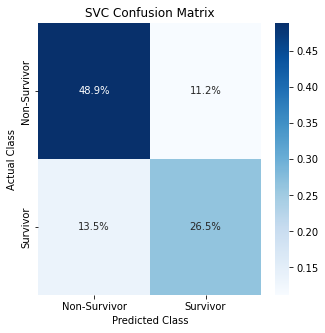

In [24]:
cm = confusion_matrix(y_test, y_test_pred_ab)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(cm/np.sum(cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('SVC Confusion Matrix')
matrix.set_xlabel('Predicted Class')
matrix.set_xticklabels(['Non-Survivor', 'Survivor'])
matrix.set_ylabel('Actual Class')
matrix.set_yticklabels(['Non-Survivor', 'Survivor'])

Gridsearch random forest model

In [40]:
rf_gs_dict = {'criterion': ['gini', 'entropy'],
              'max_features': [.2, .4, .6, .8, 1],
              'max_samples': [.03, .035, .04, .045, .05],
              'min_impurity_decrease': [.012, .013, .014, .015, .016]}
rf_gs_model = RandomForestClassifier(random_state=712, n_jobs=-1)
rf_gs = GridSearchCV(rf_gs_model, rf_gs_dict, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
rf_gs.fit(x_train, y_train)

print(rf_gs.best_estimator_)
print(rf_gs.best_score_)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
RandomForestClassifier(max_features=0.4, max_samples=0.045,
                       min_impurity_decrease=0.012, n_jobs=-1,
                       random_state=712)
0.8143867130512848


Fit and evaluate top performing random forest model

In [25]:
rf = RandomForestClassifier(criterion='gini', max_features=0.4, max_samples=0.045,
                       min_impurity_decrease=0.012, n_jobs=-1, random_state=712)
rf.fit(x_train, y_train)
y_train_pred_rf = rf.predict(x_train)
y_test_pred_rf = rf.predict(x_test)
print('Random Forest: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_rf))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_rf))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_rf))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_rf))

Random Forest: 
Train f1 Score:  0.7030878859857482
Train Accuracy Score: 0.812874251497006
Test f1 Score:  0.7074829931972789
Test Accuracy Score: 0.8071748878923767


Create Random Forest confusion matrix

[Text(0, 0.5, 'Non-Survivor'), Text(0, 1.5, 'Survivor')]

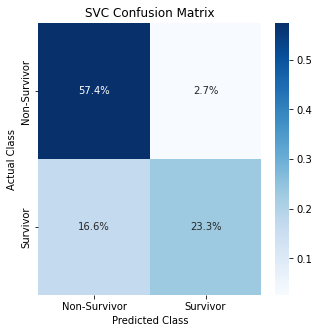

In [26]:
cm = confusion_matrix(y_test, y_test_pred_rf)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(cm/np.sum(cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('SVC Confusion Matrix')
matrix.set_xlabel('Predicted Class')
matrix.set_xticklabels(['Non-Survivor', 'Survivor'])
matrix.set_ylabel('Actual Class')
matrix.set_yticklabels(['Non-Survivor', 'Survivor'])

Gridsearch XGBoost model

In [56]:
xgb_gs_dict = {'colsample_bynode': [.2, .4, .6, .8, 1],
               'gamma': [.05, .0525, .055, .0575, .06],
               'learning_rate': [1, 1.025, 1.05, 1.075, 1.1],
               'reg_lambda': [2.4, 2.45, 2.5, 2.55, 2.6],
               'subsample': [.105, .1075, .11, .1125, .115]}
xgb_gs_model = XGBClassifier(random_state=137, n_jobs=-1)
xgb_gs = GridSearchCV(xgb_gs_model, xgb_gs_dict, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
xgb_gs.fit(x_train, y_train)

print(xgb_gs.best_estimator_)
print(xgb_gs.best_score_)

Fitting 5 folds for each of 3125 candidates, totalling 15625 fits
[18:32:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=0.2, colsample_bytree=1,
              enable_categorical=False, gamma=0.0525, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=1.075, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=137, reg_alpha=0, reg_lambda=2.6,
              scale_pos_weight=1, subsample=0.11, tree_method='exact',
              va

C:\Users\blant\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fit and evaluate top perfomring gridsearch xgboost model

In [59]:
xgb = XGBClassifier(colsample_bynode=0.2, gamma=0.0525, learning_rate=1.075, reg_lambda=2.6, subsample=0.11,
                                          random_state=137, n_jobs=-1)
xgb.fit(x_train, y_train)
y_train_pred_xgb = xgb.predict(x_train)
y_test_pred_xgb = xgb.predict(x_test)
print('XGBoost: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_xgb))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_xgb))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_xgb))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_xgb))

[18:59:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost: 
Train f1 Score:  0.6666666666666666
Train Accuracy Score: 0.7874251497005988
Test f1 Score:  0.6754966887417219
Test Accuracy Score: 0.7802690582959642


C:\Users\blant\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [122]:
vc = VotingClassifier([('lr', lr), ('xgb', xgb)], voting='soft', weights=[1, .05])
vc.fit(x_train, y_train)
y_train_pred_vc = vc.predict(x_train)
y_test_pred_vc = vc.predict(x_test)
print('Voting Classifier: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_vc))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_vc))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_vc))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_vc))

[19:48:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Voting Classifier: 
Train f1 Score:  0.7030878859857482
Train Accuracy Score: 0.812874251497006
Test f1 Score:  0.7074829931972789
Test Accuracy Score: 0.8071748878923767


C:\Users\blant\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


# Deploy

In [243]:
deploy_df = pd.read_csv('../Data/test.csv')
deploy_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [244]:
deploy_df.drop(columns=['Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin'], inplace=True)
deploy_df.set_index('PassengerId', inplace=True)
deploy_df.head()

,Pclass,Sex,Embarked
PassengerId,,,
892,3,male,Q
893,3,female,S
894,2,male,Q
895,3,male,S
896,3,female,S


In [245]:
deploy_df = pd.get_dummies(deploy_df, columns=['Pclass', 'Sex', 'Embarked'])
deploy_df.drop(columns=['Pclass_2', 'Sex_female', 'Embarked_Q'], inplace=True)
deploy_df.head()

,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S
PassengerId,,,,,
892,0,1,1,0,0
893,0,1,0,0,1
894,0,0,1,0,0
895,0,1,1,0,1
896,0,1,0,0,1


In [246]:
deploy_df = pd.DataFrame(ss.transform(deploy_df), columns=deploy_df.columns, index=deploy_df.index)
deploy_df.head()

,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S
PassengerId,,,,,
892,-0.549676,0.873231,0.724648,-0.482154,-1.621862
893,-0.549676,0.873231,-1.379981,-0.482154,0.616575
894,-0.549676,-1.145172,0.724648,-0.482154,-1.621862
895,-0.549676,0.873231,0.724648,-0.482154,0.616575
896,-0.549676,0.873231,-1.379981,-0.482154,0.616575


In [247]:
deploy_y_pred = lr.predict(deploy_df)
upload_df = pd.DataFrame()
upload_df['PassengerId'] = deploy_df.index
upload_df['Survived'] = deploy_y_pred
upload_df.head()

,PassengerId,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,0.0
4,896,0.0


In [250]:
upload_df.to_csv('../Data/Submission.csv', index=False)